# Backpropagation

In this notebook we have a look at how to implement backpropagation using (batched) matrix multiplication. We will see how activations that are computed in the forward computation of a neural network (or any other function!) can be re-used when computing gradients of the function with respect to its parameters/weights.

To do so, we create a small artificial dataset of a 1D sine function.

### (OPTIONAL) Historical background: Learning rule of a single perceptron (layer)

A single perceptron (or a layer of perceptrons for multivariate targets) can be trained with a simple learning rule, the **Delta rule** that Frank Rosenblatt came up with already in 1958:
$$\Delta w_k^i = \eta (y^i- \hat{y}^i) x_k$$

where $\eta$ is a **learning rate**.

Since a single layer of perceptrons can only discriminate between linearly separable input features, there is a need to use multiple perceptron layers stacked on top of each other. This limitation of perceptrons, and the lack of efficient weight update schemes for multi-layer perceptrons (and Rosenblatt's death before he could write a reply to criticism from symbolic AI proponent Marvin Minsky) effectively led to a first winter in ANN research. But now how do we update the weights in an MLP?

To know how to update a weight, we need to know its contribution to the output of the MLP. How to do this efficiently was eventually figured out when David Rumelhart and Geoffrey Hinton came up with the idea of **error backpropagation** in 1985 while working on a research program they called _"Parallel Distributed Processing"_.

The idea of backpropagation is to compute the gradients of the loss with respect to the weights. In the single layer case this could be done by the delta rule, so what the backpropagation represents is a **generalization of the delta rule** to the case where we have multiple layers of perceptrons.

Later on, the idea of backpropagation was further generalized to yield algorithms for **automatic differentiation** on any function for which we know the derivatives of the individual local computations involved.

Before diving into the idea of automatic differentiation, the aim of which is to have an efficient way of computing the gradients of the loss function with respect to the weights, we need to understand what _gradients of the loss function_ actually means and why finding these gradients would be useful for optimizing neural networks.

## Gradient Descent

The idea of gradient descent is that we can find minima of a function by following the opposite of its **gradient**. The gradient of a function of a vector of weights $\vec{w}$ can be written as $\nabla_{\vec{w}} f(\vec{w})$ and it is a vector of the partial derivatives of $f$ with respect to each element $w_i$ in $\vec{w}$:

$$\nabla_{\vec{w}} f(\vec{w}) = \begin{pmatrix} \frac{\partial f}{\partial w_0} \\\frac{\partial f}{\partial w_1} \\... \\ \frac{\partial f}{\partial w_n}\end{pmatrix}$$

This gradient points in a linearized way into the **locally steepest direction of function value increase**. If we want to minimize an error function, the idea is to follow the opposite direction of this gradient. By iteratively following and re-computing the gradient in **small steps**, we can end up reducing the error function. Given that $f$ is convex (meaning there exist no local minima that are not identical to the global minimum) and we take small enough steps, convergence to the global minimum is guaranteed.

## Back to Backpropagation

We are interested in finding the partial derivatives of a loss/error function with respect to the weights. From calculus we know a bunch of rules that govern differentiation. Of particular interest to us is the **chain rule of calculus**: 

If we have a composite function $f(x) = g(h(x))$, then $$f'(x) = g'(h(x)) h'(x)$$

Now with an MLP we do have such a composite function in the sense that one layer computes an output which then is the input to the next layer. In fact with two layers, we could define one layer as $g$ and the other layer as $h$ and yet another function $\mathcal{L}$ as the error or **loss** function. Finding the gradients $\nabla_w \mathcal{L(w)}$ can be decomposed into finding partial derivatives of the layers $g$ and $h$. 

The idea is that we can first compute the partial derivatives of the outermost functions/layers and then, to obtain the derivatives of the earlier layers, we can multiply them with what we already computed for the outer functions. We have  $f = \mathcal{L}(g(w_1, h(w_0, x)))$ and we want $f_w1'$, we need to first differentiate through the loss function. 

For the mean squared error $\mathcal{L}_{\text{MSE}} = \frac{1}{2} (\hat{y}_w - y)^2$ this equals $\hat{y}_w - y$. To then obtain the gradients w.r.t the weights $w_1$ of the outermost layer $g$, we multiply $\hat{y}_w - y$ with $g'_w(x)$. The same logic applies to the weights of layer $h$. Once we have the derivatives of the next layer's weights, we can compute the derivatives for the previous layer's weights etc.. It is for this logic that comes from applying the chain rule, that it was called backpropagation.

As it turns out, to compute the gradients in this fashion, it is highly useful to keep track of intermediate results during the **forward pass** (calling the MLP on an input). The general logic of training MLPs thus is to first compute a prediction with a model and keep intermediate outputs in memory before using these values in the backward pass.

## Automatic Differentiation

While the original backpropagation learning rule was special to computations occuring in multi-layer perceptrons, a more modern approach is to have a library that tracks the **computational graph** and for each basic operation knows the derivative. During the backward pass the computational graph is reversely followed, making use of our knowledge of the derivatives of the individual small computations. With an automatic differentiation framework such as Tensorflow we can compute gradients (and thus perform gradient descent based optimization) on arbitrary functions that do not even have to be considered neural networks.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2022-11-03 15:59:33.055713: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-03 15:59:33.378791: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-03 15:59:33.378818: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-03 15:59:33.419776: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-03 15:59:34.456781: W tensorflow/stream_executor/platform/de

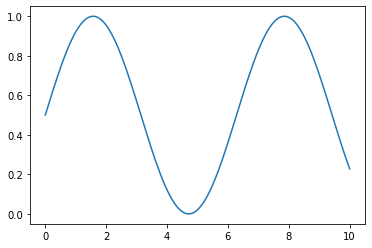

2022-11-03 15:59:37.215188: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-03 15:59:37.215465: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-03 15:59:37.215491: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-ATOP1V9): /proc/driver/nvidia/version does not exist
2022-11-03 15:59:37.217426: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# this is the non-linear function we want to learn
x = np.linspace(0,10, num=128, dtype=np.float32)
x = x.reshape(x.shape[0], 1)
y = np.sin(x) * 0.5 + 0.5 # sine between 0 and 1

# show training data
plt.plot(x, y)
plt.show()

# create data, a single example for simplicity
batch_size=1

inputs = np.random.uniform(low=0.0, high=10,
                           size=batch_size).astype(np.float32)
inputs = inputs.reshape(batch_size, 1)
target = np.sin(inputs)*0.5 + 0.5

# turn numpy arrays into tensorflow tensors
inputs = tf.constant(inputs)
target = tf.constant(target)


Next we create a neural network (multi-layer perceptron) that takes this data and transforms it, using linear transformations (matrix multiplication) and non-linear activation functions (sigmoid), to compute predictions of the sine value.

We will use 3 layers. The first layer has 20 hidden units, the second layer has 10 hidden units and the third layer, which is the output layer, has 1 unit (just like the target). We use tensorflow instead of numpy but really we use it in pretty much the same way as numpy.

The weight matrices have shape (1,20), (20,10) and (10,1), following the convention (n_in, n_out).

In [3]:
weights_1 = tf.random.uniform(shape=(1,20))
weights_2 = tf.random.uniform(shape=(20,10))
weights_3 = tf.random.uniform(shape=(10,1))

### The forward computation of an ANN

Next we define the computations in which these weights are used.

We have 3 layers and we want to apply a sigmoid activation function after every layer.

We also compute the error between the output and the target values using a **Mean Squared Error**.

In [4]:
# layer 1
f7_o = inputs @ weights_1
# activation function of layer 1
f6_o = tf.nn.sigmoid(f7_o)

# layer 2
f5_o = f6_o @ weights_2
# activation function of layer 2
f4_o = tf.nn.sigmoid(f5_o)

# layer 3 (output layer)
f3_o = f4_o @ weights_3
# activation function of layer 3 (output layer)
f2_o = tf.nn.sigmoid(f3_o)

# error function, here MSE
f1_o = tf.reduce_mean(0.5 * (f2_o - target)**2, axis=None) # mean squared error

print(f"predictions are {f2_o.numpy().squeeze()} \n while the targets are {target.numpy().squeeze()}")
print(f"\n This makes a mean squared error of {f1_o}")

predictions are 0.9623635411262512 
 while the targets are 0.8839762210845947

 This makes a mean squared error of 0.0030722860246896744


Our model can be described as a composite function of 7 computations, most of which are already composite functions (e.g. sigmoid activation function or the MSE-loss):

$$\mathcal{L} = f_1(f_2(f_3( f_4(f_5(f_6(f_7(x,w_1)), w_2  )  ) ) , w_3)   , \text{target})$$

What we want to find is the tuple of partial derivatives, that is the gradient, of $f_1$ w.r.t. the parameters ($w_1, w_2, w_3$).

#### Using the chain rule

Because this is a composite function we can apply the **chain rule** of calculus, according to which the derivative is computed as the outer derivative given the unchanged output of the inner function, multiplied by the derivative of the inner function, again keeping its input unchanged, if $x$ in the formula below turns out to be another function:

$$\frac{d}{{dx}}\left[ {f_1\left( f_2 \right)} \right] = \frac{d}{{df_2}}\left[ {f_1\left( f_2 \right)} \right]\frac{{df_2}}{{dx}}$$

### Local derivatives

All we need to compute the partial derivatives of the loss function w.r.t. the network parameters (here only the weights, since we do not use a bias) is the derivatives of the individual or composite computations involved.

Our composite function (the joint forward pass and loss computation of an ANN) makes use of three kinds of composite computations:
- Mean squared error (MSE)
- Sigmoid activation function
- Matrix multiplication

### Local derivatives of MSE

$\mathcal{L}_{\text{MSE}} = f_1(\text{f2_o}) = \frac{1}{2} (\text{f2_o} - \text{t})^2$

The derivative of this w.r.t. the ANN's final layer's output *f2_o* is

$\frac{\partial \mathcal{L}}{\partial \text{f2_o}} = \text{f2_o} - \text{t}$

### Local derivatives of the sigmoid activation function

Activation functions are typically denoted as $\sigma(x)$. Here, the sigmoid activation function is defined by:

$\sigma(x) = \frac{1}{1+\text{e}^{-x}}$

and its derivative turns out to be

$\frac{\partial \sigma}{\partial \text{x}} = \sigma(x) ( 1 - \sigma(x))$

Since an activation function is an element-wise operation, we also chain this local derivative $\sigma'(x)$ with $\frac{\partial \mathcal{L}}{\partial \sigma(x)}$ by element-wise multiplication.

### Local derivatives of matrix multiplication

A matrix multiplication is a linear operation that takes two arguments, so we can differentiate w.r.t. either the first matrix or the second matrix - in neural networks this is either the input to the layer or the weights of that layer.

Let's say we have the following matrix multiplication

$C = A B$

and we already have the gradients of the loss function w.r.t. the output of this matrix multiplication C, that is we have $\frac{\partial \mathcal{L}}{\partial C}$.

The partial derivative of the loss $\mathcal{L}$ w.r.t. $A$ turns out to be

$\frac{\partial \mathcal{L}}{\partial A} = \frac{\partial \mathcal{L}}{\partial C} B^{\text{T}}$.

Likewise the partial derivative w.r.t. matrix $B$ turns out to be

$\frac{\partial \mathcal{L}}{\partial B} = A^{\text{T}} \frac{\partial \mathcal{L}}{\partial C}$.

**For a handwritten explanation, please refer to the additional material provided in the same folder as this notebook.**


This is it, we know all the local derivatives involved in the computation of the loss that we want to minimize by changing the weights in the three layers. 

Let's have another look at the forward computation of the loss, in which we store intermediate computations and later refer to them in the math notation of the backpropagation by their variable names, hopefully making it easier to relate the math to the code:

In [5]:
# layer 1
f7_o = tf.matmul(inputs, weights_1)
# activation function of layer 1
f6_o = tf.nn.sigmoid(f7_o)

# layer 2
f5_o = tf.matmul(f6_o, weights_2)
# activation function of layer 2
f4_o = tf.nn.sigmoid(f5_o)

# layer 3 (output layer)
f3_o = tf.matmul(f4_o, weights_3)
# activation function of layer 3 (output layer)
f2_o = tf.nn.sigmoid(f3_o)

# error function, here MSE
f1_o = tf.reduce_mean(0.5 * (f2_o - target)**2,axis=None) # mean squared error

print(f"prediction is {f2_o.numpy().squeeze()} while target is {target.numpy().squeeze()}")
print(f"\n This makes a mean squared error of {f1_o}")

prediction is 0.9623635411262512 while target is 0.8839762210845947

 This makes a mean squared error of 0.0030722860246896744


### Backpropagation

We start with the partial derivative of the mean squared error w.r.t. the network output f2_o:
$$\frac{\partial \mathcal{L}}{\partial f_2} = \text{f2_o} - \text{t}$$

Next we want to differentiate through the sigmoid activation function. We take an element-wise product between the outer derivative and the inner derivative $\sigma'(x)$, the definition of which you can find in the *local derivatives* section.

$$\frac{\partial \mathcal{L}}{\partial f_3} = \frac{\partial \mathcal{L}}{\partial f_2} \circ \sigma'(\text{f3_o})$$

We can already compute the gradients w.r.t. the weights of the last layer. We use the result we got above in the *local derivatives* section to know how to do this.

$$\frac{\partial \mathcal{L}}{\partial \text{W}_3} = \text{f4_o}^{\text{T}} \frac{\partial \mathcal{L}}{\partial f_3}$$

Now we want to differentiate with respect to the last layer's input, f4_o - again using the logic from the *local derivatives* section.

$$\frac{\partial \mathcal{L}}{\partial f_4} = \frac{\partial \mathcal{L}}{\partial f_3} {\text{W}_3}^{\text{T}}$$

The next step to differentiate through backwards is again a sigmoid activation function. We can thus follow the same procedure as we did before:

$$\frac{\partial \mathcal{L}}{\partial f_5} = \frac{\partial \mathcal{L}}{\partial f_4} \circ \sigma'(\text{f5_o})$$

Now we want to differentiate through the matrix multiplication of layer 2, first w.r.t. the layer's input:

$$\frac{\partial \mathcal{L}}{\partial f_6} = \frac{\partial \mathcal{L}}{\partial f_5} {\text{W}_3}^{\text{T}}$$

We can now get the gradients of the weights of layer 2, by differentiating the same matmul operation from the forward computation w.r.t. the weights, following the same logic as before for the gradients of weights_3:

$$\frac{\partial \mathcal{L}}{\partial \text{W}_2} = \text{f6_o}^{\text{T}} \frac{\partial \mathcal{L}}{\partial f_6}$$

This is becoming quite repetitive - given that we have the gradients of the loss function w.r.t. the second layer's inputs, we can differentiate through the activation function of layer 1:

$$\frac{\partial \mathcal{L}}{\partial f_7} = \frac{\partial \mathcal{L}}{\partial f_6} \circ \sigma'(\text{f7_o})$$

Sometimes we are interested in the gradients of the loss w.r.t. the input data. We can obtain these by differentiating through the matrix multiplication of the first layer w.r.t. the inputs:

$$\frac{\partial \mathcal{L}}{\partial \text{inputs}} = \frac{\partial \mathcal{L}}{\partial f_7}  {\text{W}_1}^{\text{T}}$$

Finally, and lastly, we compute the gradients of the loss $\mathcal{L}$ w.r.t. the first layer's weights:

$$\frac{\partial \mathcal{L}}{\partial \text{W}_1} = \text{f7_o}^{\text{T}} \frac{\partial \mathcal{L}}{\partial f_7}$$

In [6]:
# Gradients of MSE (d L/ d f2)
grad_f1_o = (f2_o - target)

# Chain gradients of MSE with gradients of output activation function
# (d L / d f3)
grad_f2_o = grad_f1_o *(tf.nn.sigmoid(f3_o)*(1-tf.nn.sigmoid(f3_o)))

# compute gradients w.r.t the last layer's weights (weights_3)
# (d L / d weights_3)
grad_w3 = (tf.transpose(f4_o) @ grad_f2_o) / batch_size

# chain with derivative of matrix multiplication of layer 3
# d L / d f4
grad_f3_o = grad_f2_o @ tf.transpose(weights_3)

# chain with derivative of activation function (layer 3)
# d L / d f5
grad_f4_o = grad_f3_o * (tf.nn.sigmoid(f5_o)*(1-tf.nn.sigmoid(f5_o)))

# chain with derivative of matrix multiplication of layer 2
# d L / d f6
grad_f5_o = grad_f4_o @ tf.transpose(weights_2)

# compute gradients w.r.t. layer 2's weight matrix
# d L / d weights_2
grad_w2 = (tf.transpose(f6_o) @ grad_f4_o) / batch_size

# chain with layer 2's sigmoid activation function
# d L / d f7
grad_f6_o = grad_f5_o * (tf.nn.sigmoid(f7_o)*(1-tf.nn.sigmoid(f7_o)))

# compute gradients w.r.t. the input
# d L / d inputs
grad_inputs = grad_f6_o @ tf.transpose(weights_1)

# compute gradients w.r.t. layer 1's weights
# d L / d weights_1
grad_w1 = (tf.transpose(inputs) @ grad_f6_o) / batch_size

Let's check whether our implementation that we got by chaining local derivatives of atomic computations involved actually gives us the correct gradients w.r.t. to the network weights.

To do this, we rely on Tensorflow's **reverse mode automatic differentiation**, which does exactly what we just did, relying on optimized computational graph structures to reduce the number of operations.

In [7]:
with tf.GradientTape() as tape:
    tape.watch([weights_1, weights_2, weights_3])
    f7_o = tf.matmul(inputs, weights_1)
    f6_o = tf.nn.sigmoid(f7_o)
    f5_o = tf.matmul(f6_o, weights_2)
    f4_o = tf.nn.sigmoid(f5_o)
    f3_o = tf.matmul(f4_o, weights_3)
    f2_o = tf.nn.sigmoid(f3_o)

    f1_o = tf.reduce_mean(0.5 * (f2_o - target)**2) # mean squared error
    
real_grad_w1, real_grad_w2, real_grad_w3 = tape.gradient(f1_o, [weights_1,
                                                                weights_2,
                                                                weights_3])

In [8]:
tolerance = 0.000000000001
print(f"gradients for weights_1 match tensorflow oracle: \
    {np.allclose(grad_w1, real_grad_w1, atol=tolerance)}")
print(f"gradients for weights_2 match tensorflow oracle: \
    {np.allclose(grad_w2, real_grad_w2, atol=tolerance)}")
print(f"gradients for weights_3 match tensorflow oracle: \
    {np.allclose(grad_w3, real_grad_w3, atol=tolerance)}")

gradients for weights_1 match tensorflow oracle:     True
gradients for weights_2 match tensorflow oracle:     True
gradients for weights_3 match tensorflow oracle:     True


## Some (important) notes

You may encounter some unanswered questions when trying to find gradients for more complicated composite functions. One possibility is that the same weight matrix (or activation tensor) affects the loss through multiple paths. In this case we need to aggregate the gradients obtained through these paths by summation. The same applies for a case in which we have a batch of inputs and not a single (input, output) example. In this case, you also aggregate the gradients obtained for each example by averaging, as we've done above. Deep Learning frameworks do batched matrix multiplications in a highly optimized way by utilizing the capabilities for parallelism of modern graphic processing units (GPUs) or other accelerators.


## Conclusion

We have found the computations needed to obtain the gradients of our composite function w.r.t. some variables (here weights). Let's note some important observations that we may have made along the way:


- Doing it by hand is tedious and the mathematical expressions for the gradients get very long, even for a shallow neural network of just 3 layers.


- We really only need to know the local derivatives of the basic computations involved in a composite function (such as any kind of ANN) to compute gradients of the complete function.


- The intermediate computations that arise in the function's forward pass can be re-used in the backward computation of its gradients.


- The same logic can be applied for any kind of directed acyclic graph composed of smaller functions that are differentiable. As such, it can be used to compute gradients for any neural network architecture, as long as the individual network components have known local derivatives.


- In automatic differentiation frameworks (esp. in tensorflow), functions are constructed on graphs that contain inputs, parameters, as well as the operations, their local derivatives and the intermediate results to be re-used in the backward pass. There is no need to chain derivatives together manually in these frameworks as we did here!

## Optional: Using the hard-coded backprop to train a neural network on the sine data

- we use batches of (x,y) samples from our 1D sine function for each gradient computation

- we initialize the weights differently (more on this in two weeks)

- we include a bias in our network

- we remove the sigmoid on the output, because it is a regression task

To train the network weights, we need four functions:
- the **forward computation** (including the loss function), that also returns the intermediate results
- the **backward (gradient) computation** that takes the results from forward computation and backpropagates the gradients to the network parameters, returning a tuple of parameter gradients.
- the **weight update**, in which we pair the gradients with their respective parameter array/tensor and subtract a fraction of the gradients from the parameters
- the **training loop** which applies the three functions for a number of iterations, computing the loss (and intermediate activations and pre-activations), backpropagating the error (computing gradients), and applying the gradients to update the weights and the biases of the network.

In [9]:
# instantiate network parameters
n_units_1 = 20
n_units_2 = 10
n_units_3 = 1

# He-Uniform initialization for better learning
limit_1 = np.sqrt(6 / 1)
limit_2 = np.sqrt(6 / n_units_1)
limit_3 = np.sqrt(6/n_units_2)

weights_1 = tf.random.uniform(minval=-limit_1,maxval=limit_1,shape=(1,n_units_1))
weights_2 = tf.random.uniform(minval=-limit_2,maxval=limit_2,shape=(n_units_1,n_units_2))
weights_3 = tf.random.uniform(minval=-limit_3,maxval=limit_3, shape=(n_units_2,n_units_3))

# this time using a bias in our model
bias_1 = tf.Variable(tf.zeros(n_units_1))
bias_2 = tf.Variable(tf.zeros(n_units_2))
bias_3 = tf.Variable(tf.zeros(n_units_3))

weights_1 = tf.Variable(weights_1)
weights_2 = tf.Variable(weights_2)
weights_3 = tf.Variable(weights_3)

weights = (weights_1, weights_2, weights_3, bias_1, bias_2, bias_3)

In [17]:
@tf.function(jit_compile=True) # for speed
def compute_forward_pass(inputs, target, weights):
    
    weights_1 = weights[0]
    weights_2 = weights[1]
    weights_3 = weights[2]
    bias_1 = weights[3]
    bias_2 = weights[4]
    bias_3 = weights[5]
    
    # layer 1, now with bias
    f7_o = tf.matmul(inputs, weights_1) + bias_1
    # activation function of layer 1
    f6_o = tf.nn.sigmoid(f7_o)
    
    # layer 2, now with bias
    f5_o = tf.matmul(f6_o, weights_2) + bias_2
    # activation function of layer 2
    f4_o = tf.nn.sigmoid(f5_o)

    # layer 3 (output layer), now with bias
    f3_o = tf.matmul(f4_o, weights_3) + bias_3
    # activation function of layer 3 (output layer)
    # skip the last layer's sigmoid f2_o = tf.nn.sigmoid(f3_o) 

    # error function, here MSE
    f1_o = tf.reduce_mean(0.5 * (f3_o - target)**2,axis=None) # mean squared error

    return (f1_o, f3_o, f4_o, f5_o, f6_o, f7_o, inputs)

In [18]:
@tf.function(jit_compile=True) # for speed
def compute_gradients(weights, data_from_forward, target, batch_size):
    
    # unpack weights and data from the forward-step
    (weights_1, weights_2, weights_3, bias_1, bias_2, bias_3) = weights
    (f1_o, f3_o, f4_o, f5_o, f6_o, f7_o, inputs) = data_from_forward
    
    # Gradients of MSE (d L/ d f2)
    grad_f1_o = (f3_o - target)
    
    # we skipped the output layer's sigmoid

    # chain with derivative of matrix multiplication of layer 3
    # d L / d f4
    grad_f3_o = grad_f1_o @ tf.transpose(weights_3)
    
    # compute gradients w.r.t the last layer's weights (weights_3)
    # (d L / d weights_3)
    grad_w3 = (tf.transpose(f4_o) @ grad_f1_o) / batch_size
    
    # (d L / d bias_3)
    grad_b3 = tf.reduce_sum(grad_f1_o,axis=0) / batch_size

    # chain with derivative of activation function (layer 3)
    # d L / d f5
    grad_f4_o = grad_f3_o * (tf.nn.sigmoid(f5_o)*(1-tf.nn.sigmoid(f5_o)))

    # chain with derivative of matrix multiplication of layer 2
    # d L / d f6
    grad_f5_o = grad_f4_o @ tf.transpose(weights_2)

    # compute gradients w.r.t. layer 2's weight matrix
    # d L / d weights_2
    grad_w2 = (tf.transpose(f6_o) @ grad_f4_o) / batch_size
    
    # (d L / d bias_2)
    grad_b2 = tf.reduce_sum(grad_f4_o,axis=0) / batch_size

    # chain with layer 2's sigmoid activation function
    # d L / d f7
    grad_f6_o = grad_f5_o * (tf.nn.sigmoid(f7_o)*(1-tf.nn.sigmoid(f7_o)))

    # compute gradients w.r.t. the input
    # d L / d inputs
    grad_inputs = grad_f6_o @ tf.transpose(weights_1)

    # compute gradients w.r.t. layer 1's weights
    # d L / d weights_1
    grad_w1 = (tf.transpose(inputs) @ grad_f6_o) / batch_size
    
    # (d L / d bias_1)
    grad_b1 = tf.reduce_sum(grad_f6_o,axis=0) / batch_size

    return (grad_w1, grad_w2, grad_w3, grad_b1, grad_b2, grad_b3)

In [19]:
def update_weights(weights, weight_gradients, learning_rate=1e-2):
    for w, w_grad in zip(weights, weight_gradients):
        w = w.assign(w - learning_rate*w_grad)
    return weights

In [20]:
def minimize_loss(weights, batch_size, steps, 
                  learning_rate):
    # random subset of data
    losses = []
    for i in range(steps):
        
        # create training data on the fly
        inputs = np.random.uniform(low=0.0, high=10,size=batch_size).astype(np.float32)
        inputs = inputs.reshape(batch_size, 1)
        target = np.sin(inputs)*0.5 + 0.5

        # turn numpy arrays into tensorflow tensors
        random_inputs = tf.constant(inputs)
        random_target = tf.constant(target)
        
        data_from_forward = compute_forward_pass(random_inputs, 
                                                 random_target, 
                                                 weights)
        # report loss every 100 epochs
        losses.append(data_from_forward[0])
        if not i%8000: 
            print(f"loss is {np.mean(losses)}")
            losses = []

        grads = compute_gradients(weights, data_from_forward, 
                                  random_target, 
                                  batch_size=batch_size)

        weights = update_weights(weights,grads,learning_rate=learning_rate)
        
    return weights

In [21]:
trained_weights = minimize_loss(weights=weights,
                      batch_size=128, steps=300000,
                      learning_rate=0.01)

2022-11-02 15:12:52.839318: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x555790ddc5f0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-11-02 15:12:52.839357: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Host, Default Version
2022-11-02 15:12:52.869156: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-11-02 15:12:53.050489: I tensorflow/compiler/jit/xla_compilation_cache.cc:476] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


loss is 1.367553472518921
loss is 0.05443808063864708
loss is 0.050000909715890884
loss is 0.04771801084280014
loss is 0.04488663375377655


KeyboardInterrupt: 

In [10]:
# create test data
x = np.linspace(0,10,1000).astype(np.float32)
x = x.reshape(1000,1)
y = np.sin(x)*0.5 + 0.5

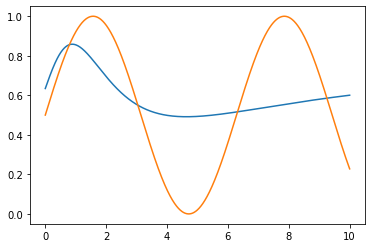

In [23]:
prediction = compute_forward_pass(x, y, weights)[1]
plt.plot(x, prediction.numpy())
plt.plot(x, y)
plt.show()